# The floating escalator: Combining 1559 and the escalator

We've discussed EIP 1559 over the course of several notebooks. A competing proposal, dubbed "escalator", was introduced by Dan Finlay, taking inspiration from a paper by Agoric.

We take the current first-price auction paradigm as our benchmark. 1559 pushes the transaction fee market on an axis where a _reasonable_ fee is mandated to transact, where by "reasonable" we mean that the fee is dynamic and governed by supply and demand. Users become price-takers most of the time, with their only decision being whether to transact or not.

The escalator proposal is a somewhat orthogonal direction for the fee market. It retains some aspect of the first-price auction mechanism (users competing against each other) but allows users to "bump up" their bid following a linear formula. For instance, I initially bid 10 and specify that with each passing block, my bid should be increased by 5, until it reaches some maximum that I also defined. If I am included immediately, my gas price is 10. One block later, it is 15, etc.

The pattern of resubmitting transactions at a higher bid is known to most users of Ethereum. The escalator "automates" it in the sense that users do not need to manually resubmit, but set the parameters for the fee increase once and for all then send the transaction to the pool.

So on one axis we have a protocol-determined objective fee equalising supply and demand. On the other, we have control over bidding behaviour. The first is useful most of the time, in particular when demand is stationary. Yet the second may be desirable for these short periods where demand drastically changes and user behaviour reverts to strategic first-price auction-style bidding. Could we combine the two?

In this notebook, we investigate the **floating escalator**, a proposal to do so. We'll introduce its dynamics and study some user behaviours under this paradigm.

## Setting up

Find in the [README](../README.md) more instructions on how to run this notebook. We'll import objects from our library and introduce them in the following.

In [1]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import (
    UserFloatingEsc,
)

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

from abm1559.txs import (
    TxFloatingEsc,
)

import pandas as pd
import numpy as np
import seaborn as sns

## Floating escalator 101

Since the floating escalator relies on a combination of both 1559 and the escalator, let's introduce each once again.

### Basefee in 1559

EIP 1559 targets a specific block size $c$. When blocks are too full, a price known as the _basefee_ increases. More people want in? Fine, we'll raise the prices then. Over time, the basefee fluctuates, with higher values reached when more users want to transact.

The basefee is governed by a simple equation

$$ b_{t+1} = b_t (1 + \frac{g_t - c}{cd}) $$

where $g_t$ is the amount of gas used by block $t$. Note that blocks here can use a maximum of $2c$ gas. When they do, and are full, the update rule above becomes $b_{t+1} = b_t (1 + \frac{1}{d})$. $d$ is currently set at 8, which implies that the basefee after a full block increases by 12.5% (and basefee after an empty block decreases by 12.5%).

### Escalator

In the escalator paradigm, a user submits their starting bid $\underline{p}$, the length of time this bid is valid for $\ell$ blocks (say between blocks $T$ and $T + \ell$) and their maximum bid $\overline{p}$. Over $\ell$ blocks, the true bid $\hat{p}_t$ at block $t$ follows a linear interpolation of $\underline{p}$ and $\overline{p}$, with

$$\hat{p} = \underline{b} + \frac{t - T}{\ell} (\overline{b} - \underline{b}) $$

In other words, the bid escalates slower or faster, depending on how much time it is valid for and how high the maximum bid is.

### Floating escalator

One issue with the escalator is that users need to set a larger number of parameters to specify (start bid, max bid, duration of the escalator). Meanwhile, 1559 gives us this nice gas price "oracle" that tells you the market conditions as you start transacting. Combining the two would be nice! Our escalator could "start" on the current 1559-predicated price, the basefee, and climb their bid from there!

What exactly climbs in the floating escalator? Remember that 1559 users specify a gas premium, or the maximum amount that a miner can receive from including the transaction. We've seen in times of transitions, e.g., a demand spike, users can win by becoming strategic and "overbidding" (compared to some premium exactly equal to the economic cost for a miner to include one extra transaction).

We call this hybrid "floating": we see the basefee as a kind of tide, rising and lowering with demand. The escalator starts at or near the tide. Meanwhile, the gas premium offered to the miners climbs _in excess_ of the basefee. For instance, assume Alice starts her escalator at the basefee equal to 5 Gwei and increases the bid by 1 Gwei each block. She also specifies that she never wants to pay more than 15 Gwei.

<AxesSubplot:xlabel='block_height'>

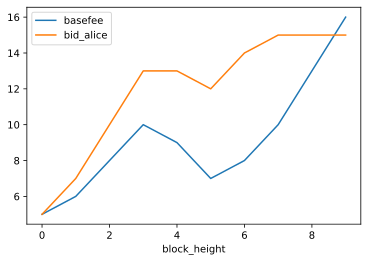

In [2]:
basefees = [5, 6, 8, 10, 9, 7, 8, 10, 13, 16]
bids_alice = [min(15, basefees[i] + i) for i in range(10)]

df = pd.DataFrame({
    "block_height": range(10),
    "basefee": basefees,
    "bid_alice": bids_alice,
})
df.plot("block_height", ["basefee", "bid_alice"])

Notice the distance between the basefee in blue and Alice's bids in orange increases over time, by 1 Gwei per block. At block 6, the basefee is 8 Gwei, so Alice's bid is 14 Gwei (8 Gwei from the basefee, 6 Gwei from her escalator). Then at block 7, the basefee increases to 10 Gwei. While Alice's bid ought to be 17 Gwei (10 Gwei from the basefee, 7 Gwei from her escalator), it is capped at 15 Gwei, which is the maximum amount Alice was willing to pay. We'll assume that after 10 blocks, Alice's transaction simply drops out.

Suppose a different user, Bob, starts at the same block as Alice, with an increase of 0.5 Gwei per block, and the same 15 Gwei limit.

<AxesSubplot:xlabel='block_height'>

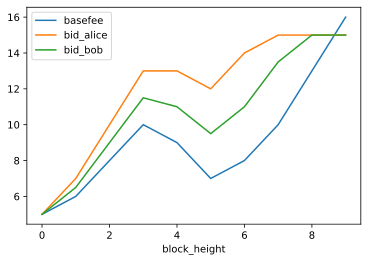

In [3]:
bids_bob = [min(15, basefees[i] + 0.5 * i) for i in range(10)]
df["bid_bob"] = bids_bob
df.plot("block_height", ["basefee", "bid_alice", "bid_bob"])

We see Bob's bids in green. Notice that they keep below Alice's bid. In a sense, Bob is more conservative than Alice is. Alice might be in a hurry to get her bid included, and doesn't mind "overpaying" if the increment she chose was too large. Bob, on the other hand, prefers to quietly escalate his bid. All things equal, Alice would be included before Bob is, since miners receive the difference between her bid and the basefee.

## User strategies in the floating escalator

In our model, users have both a _value_ for the transaction, $v$, and a cost for waiting, $c$. Getting included immediately nets you a payoff of $v$, minus the transaction fees expended. Getting included 2 blocks later, $v - 2c$, minus the transaction fees, etc.

Since $c$ represents the time preferences of the user (a higher $c$ means it is more costly for me to wait), we could decide the escalator slope based on $c$, the higher the $c$, the higher the slope and escalator increments.

We also need to decide for how long the escalator ramps up. Given increments of size $s$, after $t$ blocks, assuming a constant basefee $b$, my bid is $b + t \times s$. Meanwhile, if my transaction is included at $t$, my payoff is $v - t \times c - (b + t \times s)$. **We never want this payoff to become negative**: we would be worse off transacting than not! We can find out the number of blocks $t$ after which the previous expression becomes negative and use that as the duration of the escalator.

So how large should our increments be? We could set them to some fraction of the cost per unit, to respect the intuition that users who are more in a hurry would set higher increments. To simplify for now, we'll set them to be exactly the user's cost per unit.

In our simulations, the users' bids won't start on the basefee exactly. We'll define the `start_premium` parameter as one escalator increment: if this increment is $c$, the first bid the user places is $b + c$ [1].

We've written a "dummy" `UserFloatingEsc` class in the library that we extend here to specify the parameters discussed above.

In [4]:
class UserHurryEsc(UserFloatingEsc):
    
    def decide_parameters(self, params):
        basefee = params["basefee"]
        slope = self.cost_per_unit
        ramp_length = int(((self.value - basefee) / self.cost_per_unit - 1) / 2)
        max_fee = basefee + (ramp_length + 1) * self.cost_per_unit
        max_block = self.wakeup_block + ramp_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": basefee,
        }
        return tx_params

As in our previous notebooks, we'll write out the main simulation loop. Note that since the floating escalators have an expiry date (the max block after which they cannot be included), we add an extra step to clean up the transaction pool of expired transactions.

In [5]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])
        
        ## NEW LINE
        # We remove invalid transactions: we assume floating escalator transactions
        # "expire" after their `max_block` parameter, and so can be removed.
        txpool.remove_invalid_txs(params)

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

We'll only simulate `UserHurryEsc` first, once again setting the average number of new users spawning between two blocks at 2,500. Our blocks can only accommodate 952 of them at most.

In [6]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

shares_scenario = [{
    UserHurryEsc: 1,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

Let's observe some results!

In [7]:
df

block    basefee  users  decided_txs  included_txs  blk_avg_gas_price  \
0       0   1.000000   2480         2242           952           1.773909   
1       1   1.124900   2530         2265           952           2.014087   
2       2   1.265400   2554         2251           952           2.368470   
3       3   1.423448   2494         2158           952           2.811149   
4       4   1.601237   2468         2147           952           3.197444   
..    ...        ...    ...          ...           ...                ...   
95     95  15.142821   2523          509           509          15.604667   
96     96  15.273238   2428          452           452          15.721821   
97     97  15.176253   2382          452           452          15.614718   
98     98  15.079884   2463          463           463          15.527772   
99     99  15.027670   2576          512           512          15.487973   

    blk_avg_tip  pool_length  
0      0.773909         1290  
1      0.889187         2575  
2      1.103070         3806  
3      1.387701         4903  
4      1.596207         5925  
..          ...          ...  
95     0.461846            0  
96     0.448583            0  
97     0.438465            0  
98     0.447888            0  
99     0.460304            0  

[100 rows x 8 columns]

We recognise dynamics that should be familiar to us now. While the same average number of `users` spawn each block, and blocks are full in the first few steps, by the end of the simulation a much smaller number of users decides to actually transact (`decided_txs`). A new phenomenon is the `pool_length` being exactly zero by the end. Since transactions expire, old unincluded transactions are removed, while new transactions in the pool are all included. The basefee has reached its stationary level after which most users are priced out. This is confirmed by the following plot.

<AxesSubplot:xlabel='block'>

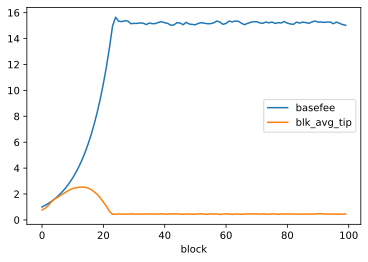

In [8]:
df.plot("block", ["basefee", "blk_avg_tip"])

Note the average tip in orange: in the first 20 blocks, when there is true competition from a shift in demand, many users want in given the low basefee amount, too many for all to be included. Those who wait in the pool see their bids escalate with increments equal to their cost per unit of waiting time. Miners of the blocks including highly escalated bids receive a much heftier tip, the difference between the user's bid and the current basefee. This comes to an end once basefee is stationary, after which priced out users do not even care to join the pool, escalating bids or not.

The question then is: does the extra transaction expressivity afforded by the escalator improve the efficiency of the fee market? We first need to be clear what efficiency means in this context. A common measure in algorithmic game theory is the _social welfare_: the total payoff received by all users (transaction senders **and** miners) minus the costs they incur.

In our case, we have users with personal values $v_i$ and cost for waiting $c_i$. We run the fee market for blocks over time period $T$, when blocks $B_1, \dots, B_T$ are produced. Transaction senders pay transaction fees to miners, so this cost to the senders is merely extra payoff for the miners. In other words, the transaction fees do not participate to the social welfare calculation. The basefee does however, it is burnt, irretrievable and constitutes a cost to the system of miners and senders [2].

$$ \text{Social welfare}((b_t)_t, (w_i)_i) = \sum_{t \in T} \sum_{i \in B_t} g_i ( v_i - w_i \times c_i - b_t) $$

where $g_i$ is the gas used by sender $i$, $w_i$ is how long the user has waited and $b_t$ is the basefee at block $t$. Note that the social welfare (SW) is determined by the realisation of $(b_t)_t$ and $(w_i)_i$, which are not exogenous to the system (while $(g_i)_i, (v_i)_i$ and $(c_i)_i$ are).

Note that the sum above is only carried over _included_ users. Users who are not included pay nothing and receive no value either [3]. Note too that all things equal, SW is higher whenever users with higher costs for waiting get in quickly, or whenever users with higher values are included.

Let's investigate all this by looking at the data of included users.

In [12]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = user_pool_df.set_index("sender").join(
    chain_df.set_index("sender"), how="right"
)

first_blocks = user_txs_df[user_txs_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")

In [13]:
g = sns.FacetGrid(data=first_blocks, col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()
g.fig.set_figwidth(8)
g.fig.set_figheight(8)

In [ ]:
class UserFixedDuration(UserFloatingEsc):
    
    def decide_parameters(self, params):
        ramp_length = 10
        max_fee = self.value - ramp_length * self.cost_per_unit
        slope = (max_fee - params["basefee"]) / (ramp_length + 1)
        max_block = self.wakeup_block + ramp_length
        start_premium = slope
        
        tx_params = {
            "max_fee": max_fee, # in wei
            "start_premium": start_premium, # in wei
            "start_block": self.wakeup_block,
            "max_block": max_block,
            "basefee": params["basefee"],
        }
        return tx_params

In [8]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    UserFloatingEsc: 1,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

In [9]:
df

block    basefee  users  decided_txs  included_txs  blk_avg_gas_price  \
0       0   1.000000   2484         2186           952           3.130764   
1       1   1.124900   2460         2156           952           3.528757   
2       2   1.265400   2506         2211           952           4.164830   
3       3   1.423448   2477         2177           952           5.036613   
4       4   1.601237   2477         2171           952           5.847867   
..    ...        ...    ...          ...           ...                ...   
95     95  13.588845   2563         2212           514          13.952520   
96     96  13.723714   2500         2195           435          14.067758   
97     97  13.575327   2560         2240           496          13.937094   
98     98  13.645918   2583         2261           493          14.017348   
99     99  13.706131   2460         2162           474          14.038387   

    blk_avg_tip  pool_length  
0      2.130764         1105  
1      2.403857         2141  
2      2.899430         3202  
3      3.613164         4198  
4      4.246630         5143  
..          ...          ...  
95     0.363675            0  
96     0.344044            0  
97     0.361768            0  
98     0.371429            0  
99     0.332256            0  

[100 rows x 8 columns]

<AxesSubplot:xlabel='block'>

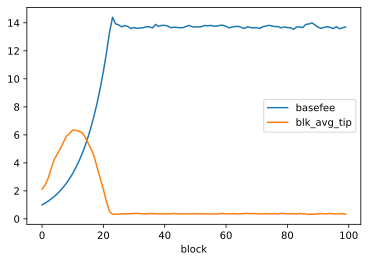

In [10]:
df.plot("block", ["basefee", "blk_avg_tip"])

<AxesSubplot:xlabel='block'>

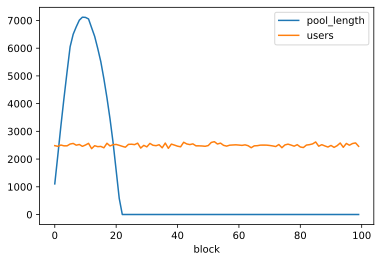

In [11]:
df.plot("block", ["pool_length", "users"])

In [12]:
from math import isnan

# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })
user_pool_df = user_pool_df.assign(slope = user_pool_df.apply(
    lambda row: (row["value"] - 5 * row["cost_per_unit"] - 2) / 5,
    axis = 1,
))

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = user_pool_df.set_index("sender").join(
    chain_df.set_index("sender"), how="outer", rsuffix = "-tx"
)
user_txs_df = user_txs_df.assign(
    included = pd.notna(user_txs_df["block_height"])
)
user_txs_df = user_txs_df.assign(
    payoff = user_txs_df.apply(
        lambda row: np.nan if pd.isna(row.block_height) else row.user.payoff({
            "current_block": row.block_height,
            "gas_price": row["tx"].gas_price({
                "basefee": row.basefee * (10 ** 9),
                "current_block": row.block_height,
            })
        }) / (10 ** 9), # put payoff is in Gwei
        axis = 1
    )
)

In [13]:
first_blocks = user_txs_df[user_txs_df.block_height <= 15].copy()
first_blocks["wakeup_block"] = first_blocks["wakeup_block"].astype("category")
first_blocks["wakeup_block"]

sender
000271db41a4b9a2    11
0003ee919ad9faa1    10
000a41b0b5301f4e     4
000e35045a5d01c1    12
001054ef5dda2227     5
                    ..
ffdb6910ca671a2c     0
fff1befdc98ee350     8
fff85244dcefca06    10
fffb9172ca204e04     1
fffe907cae5723c2     1
Name: wakeup_block, Length: 15232, dtype: category
Categories (15, int64): [0, 1, 2, 3, ..., 11, 12, 13, 14]

In [14]:
g = sns.FacetGrid(data=first_blocks[first_blocks.block_height <= 15], col="block_height", col_wrap = 4)
g.map_dataframe(sns.scatterplot, x="value", y="cost_per_unit", hue="wakeup_block", palette="muted")
g.add_legend()

---

_Footnotes_

[1] This gives the inequality $v - tc - (b + (t+1)c) > 0 \Leftrightarrow v - b - c > 2ct \Leftrightarrow t < (v-b-c)/2c$ so $t^* = \lfloor (v-b-c)/2c \rfloor$.

[2] Although perhaps not a cost to the more general population of ETH holders, but we narrow our focus to the (senders, miners) system alone here.

[3] We could model their opportunity cost of locking up funds for the duration of their transaction, but we don't do it here.